In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# ==========================================
# 1. 定义动力学方程 (严格按照 LaTeX)
# ==========================================
def dzdt_latex_defined(z, t, p, K1, K2, gamma, r1, r2):
    """
    根据提供的 LaTeX 公式计算 dz/dt
    z: [z1, z2] (complex array)
    p: 当前的固定 p 值 (稳态扫描时不随时间变化)
    """
    z1, z2 = z[0], z[1]
    q = 1.0 - p
    
    # 序参量 Z
    Z = q * z1 + p * z2
    Z_conj = np.conjugate(Z)
    
    # 防止分母为 0 的安全措施
    eps = 1e-10
    p_safe = max(p, eps)
    q_safe = max(q, eps)
    
    # 按照 LaTeX: -gamma*z - (K/2)*Z*z^2 + (K/2)*Z* + coupling
    # 注意: r1*(p/q)*(z2-z1) 是增益/耗散耦合项
    
    # z1 方程
    # term1: -gamma * z1
    # term2: -(K1/2) * Z * z1^2
    # term3: +(K1/2) * Z_star
    # term4: +r1 * (p/q) * (z2 - z1)
    dz1 = -gamma * z1 \
          - (K1 / 2.0) * Z * (z1**2) \
          + (K1 / 2.0) * Z_conj \
          + r1 * (p_safe / q_safe) * (z2 - z1)
          
    # z2 方程
    dz2 = -gamma * z2 \
          - (K2 / 2.0) * Z * (z2**2) \
          + (K2 / 2.0) * Z_conj \
          + r2 * (q_safe / p_safe) * (z1 - z2)
          
    return np.array([dz1, dz2], dtype=complex)

def rk4_step(z, t, dt, f, p, K1, K2, gamma, r1, r2):
    k1 = f(z, t, p, K1, K2, gamma, r1, r2)
    k2 = f(z + 0.5 * dt * k1, t + 0.5 * dt, p, K1, K2, gamma, r1, r2)
    k3 = f(z + 0.5 * dt * k2, t + 0.5 * dt, p, K1, K2, gamma, r1, r2)
    k4 = f(z + dt * k3, t + dt, p, K1, K2, gamma, r1, r2)
    return z + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

def integrate_to_steady_state(z_init, p, K1, K2, gamma, r1, r2, dt, steps):
    """
    从 z_init 演化 steps 步，返回最后的 z 和是否发散的标志
    """
    z = z_init
    t = 0.0
    for _ in range(steps):
        z = rk4_step(z, t, dt, dzdt_latex_defined, p, K1, K2, gamma, r1, r2)
        t += dt
        # 安全检查：如果数值爆炸，提前返回
        if np.abs(z[0]) > 10.0 or np.abs(z[1]) > 10.0:
            return z, False # Diverged
    return z, True

# ==========================================
# 2. 参数扫描主程序
# ==========================================

# 固定参数
K1 = -0.5
K2 = 1.0
gamma = 0.05
dt = 0.05        # 步长
t_hold = 200.0   # 每个点演化的时长 (如果利用上一点结果，这个时间通常足够收敛)
steps = int(t_hold / dt)

# 扫描参数设置
# 横轴：p (从 0.01 到 0.99，避开 0 和 1 以免除以零)
p_values = np.linspace(0.3, 0.95, 30) 
# 纵轴：整体速率 Total Rate = r1 + r2
rate_values = np.linspace(0, 1, 30)

# 结果矩阵
Z_total_abs = np.zeros((len(rate_values), len(p_values)))
z1_abs = np.zeros((len(rate_values), len(p_values)))
z2_abs = np.zeros((len(rate_values), len(p_values)))

print(f"开始扫描: Grid {len(rate_values)}x{len(p_values)}, Steps per point={steps}")
start_time = time.time()

for i, total_rate in enumerate(rate_values):
    # 每一行开始时，重置初始条件 (或者可以每一行也继承上一行的结果)
    # 这里选择每一行开始给一个小的随机扰动，确保能跳出上一行可能存在的死锁
    current_z = np.array([0.01+0.01j, 0.01+0.01j], dtype=complex)
    
    for j, p in enumerate(p_values):
        # 计算 r1, r2
        # 根据 p = r2 / (r1 + r2) 和 total_rate = r1 + r2
        # 推导: r2 = p * total_rate, r1 = (1-p) * total_rate
        r2_val = p * total_rate
        r1_val = (1.0 - p) * total_rate
        
        # 演化到稳态 (利用 current_z 作为初值)
        z_final, valid = integrate_to_steady_state(current_z, p, K1, K2, gamma, r1_val, r2_val, dt, steps)
        
        # 更新当前 z，供下一个 p 点使用 (绝热延拓)
        if valid:
            current_z = z_final
        else:
            # 如果发散，重置为小值
            current_z = np.array([0.01+0.01j, 0.01+0.01j], dtype=complex)

        # 计算序参量
        q = 1.0 - p
        Z_val = q * z_final[0] + p * z_final[1]
        
        # 存储模长 (取绝对值)
        # 不管是静止解还是旋转解，取模长都是常数
        Z_total_abs[i, j] = np.abs(Z_val)
        z1_abs[i, j] = np.abs(z_final[0])
        z2_abs[i, j] = np.abs(z_final[1])

    # 简易进度条
    if i % 5 == 0:
        print(f"Processing Row {i}/{len(rate_values)} (Rate={total_rate:.3f})...")

print(f"扫描完成，耗时: {time.time() - start_time:.2f} 秒")



开始扫描: Grid 30x30, Steps per point=4000
Processing Row 0/30 (Rate=0.000)...
Processing Row 5/30 (Rate=0.172)...
Processing Row 10/30 (Rate=0.345)...
Processing Row 15/30 (Rate=0.517)...
Processing Row 20/30 (Rate=0.690)...
Processing Row 25/30 (Rate=0.862)...
扫描完成，耗时: 37.56 秒


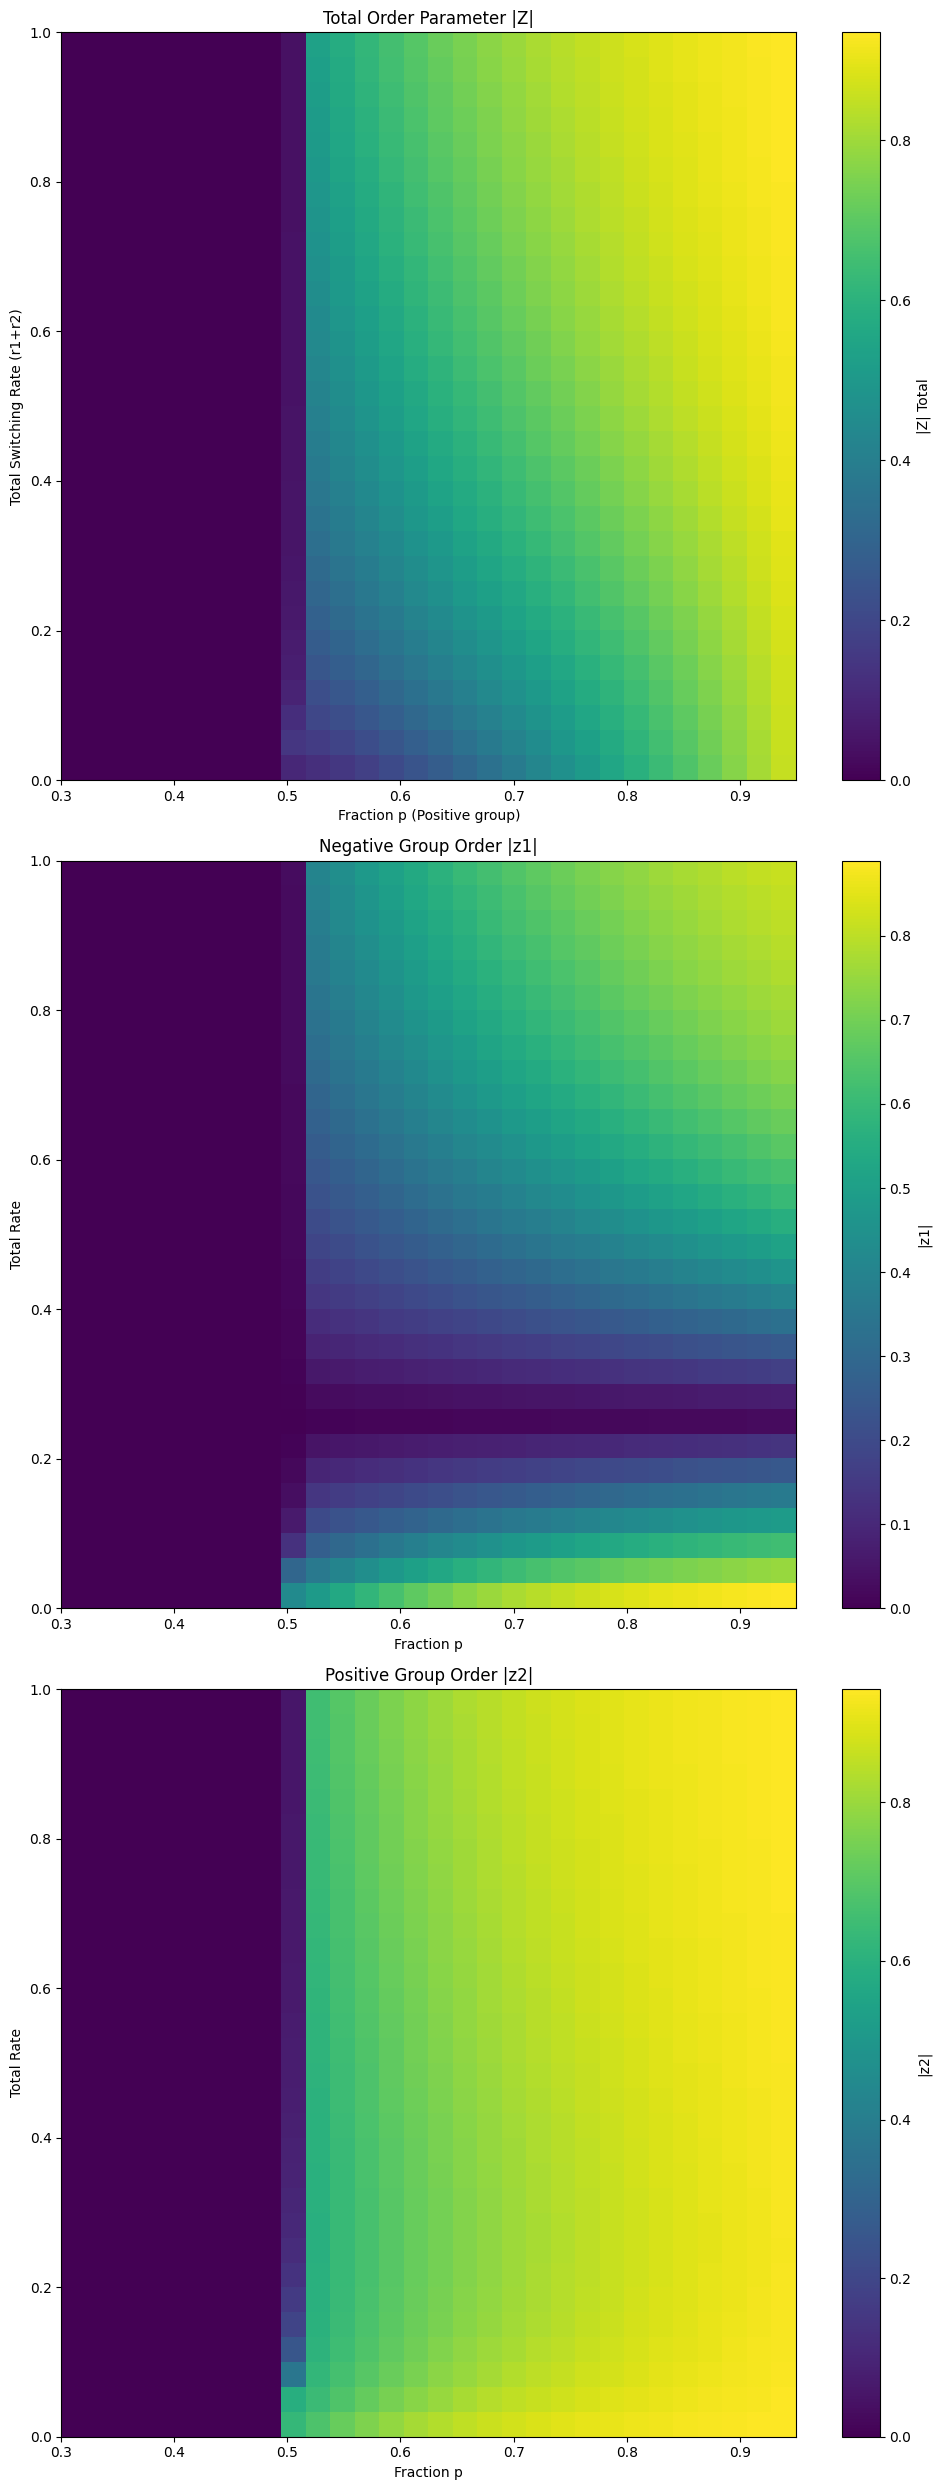


--- 稳态分析 (Last Point) ---
|Z| stability: [0. 0.]
Is Rotating? Phase change per step: [-5.e-324  0.e+000]
-> 看起来是静止解 (Fixed Point)


In [2]:
# ==========================================
# 3. 绘图
# ==========================================
plt.figure(figsize=(10, 25))

# 图 1: 总序参量 |Z|
plt.subplot(3, 1, 1)
# origin='lower' 使得纵轴 0 在下方
extent = [p_values[0], p_values[-1], rate_values[0], rate_values[-1]]
plt.imshow(Z_total_abs, aspect='auto', origin='lower', cmap='viridis', extent=extent)
plt.colorbar(label='|Z| Total')
plt.xlabel('Fraction p (Positive group)')
plt.ylabel('Total Switching Rate (r1+r2)')
plt.title('Total Order Parameter |Z|')

# 图 2: |z1|
plt.subplot(3, 1, 2)
plt.imshow(z1_abs, aspect='auto', origin='lower', cmap='viridis', extent=extent)
plt.colorbar(label='|z1|')
plt.xlabel('Fraction p')
plt.ylabel('Total Rate')
plt.title('Negative Group Order |z1|')

# 图 3: |z2|
plt.subplot(3, 1, 3)
plt.imshow(z2_abs, aspect='auto', origin='lower', cmap='viridis', extent=extent)
plt.colorbar(label='|z2|')
plt.xlabel('Fraction p')
plt.ylabel('Total Rate')
plt.title('Positive Group Order |z2|')

plt.tight_layout()
plt.show()

# 额外的验证：检查最后一个点是静止还是旋转
# 我们取最后一次迭代的倒数第2步和最后一步比较
z_prev = rk4_step(current_z, 0, -dt, dzdt_latex_defined, p, K1, K2, gamma, r1_val, r2_val) # 回退一步估算
diff = np.abs(current_z - z_prev)
angle_diff = np.angle(current_z / z_prev) # 相位差
print("\n--- 稳态分析 (Last Point) ---")
print(f"|Z| stability: {np.abs(np.abs(current_z) - np.abs(z_prev))}")
print(f"Is Rotating? Phase change per step: {angle_diff}")
if np.allclose(angle_diff, 0, atol=1e-4):
    print("-> 看起来是静止解 (Fixed Point)")
else:
    print("-> 看起来是旋转解 (Limit Cycle / Rotating Wave)")